# Anomaly detection with custom package

In this notebook, the custom anomaly detection method will be explained with a few examples on synthetic 2D data.

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from scipy import stats
import numpy as np
#Import find_outliers class to perform analysis
from AnomalyDetection import find_outliers

## 1. Data generation

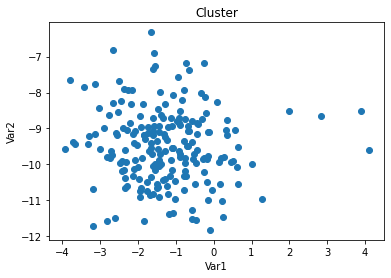

In [2]:
#Generate data
X1, y = make_blobs(n_samples=250, centers=1, n_features=2, random_state=2)
X = X1[:200,:]
#Get a test split for later
X_test = X1[200:,:]
#Add outliers to data and test
X = np.vstack([X,np.array([[4.1,-9.6],[3.9,-8.5]])])
X_test = np.vstack([X_test,np.array([[4,-11.6],[1.7,-7.5]])])
#colormap = np.array(['r', 'g', 'b'])
plt.scatter(X[:,0], X[:,1])
plt.xlabel('Var1')
plt.ylabel('Var2')
plt.title('Cluster')
plt.show()
#Some points on the right may be considered outliers

## 2. Show outlier detection methods

### 2.0 Available functions

* elliptic_envelope

* isolation_forest

* oc_svm

* local_outlier_factor

Each function accepts all parameters found in the original sklearn functions. Using the help() function on any of them will return all their information.

### 2.1 Float contamination

By sending a float nomber (between 0 and 0.5, as an estimate proportion of outliers) to the find_outliers class, the models will attempt to estimate which points are outliers based on their internal scores and parameters.

In [ ]:
#Instantiate a class for each cluster (there's only one, so only one class)
contamination = 0.02
fo_cluster0 = find_outliers(data = X, contamination = contamination, modelPath = './ClusterAnomalyModels/ODModels_Synthetic_float')

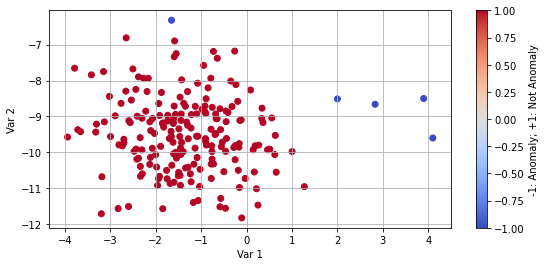

In [4]:
#Check how the elliptic envelope works, as it works best with gaussian-shaped clusters
preds_ee_float, scores_ee_float = fo_cluster0.elliptic_envelope()
plt.figure(figsize = (9, 4))
ax = plt.scatter(X[:,0], X[:,1], c = preds_ee_float, cmap = 'coolwarm')
plt.xlabel('Var 1')
plt.ylabel('Var 2')
plt.colorbar(label = '-1: Anomaly; +1: Not Anomaly')
plt.grid()
plt.show()

### 2.2 Integer contamination

When contamination is an integer (k), the class will output the topk outliers, based on the model's score.

In [ ]:
#Instantiate a class for each cluster (there's only one, so only one class)
contamination = 5#This will make models return an array of labels with only 5 outliers
fo_cluster0 = find_outliers(data = X, contamination = contamination, modelPath = './ClusterAnomalyModels/ODModels_Synthetic_int')

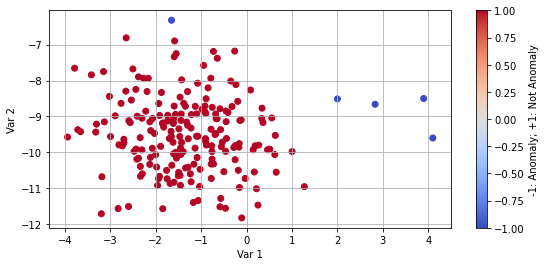

In [6]:
#Check how the elliptic envelope works, as it works best with gaussian-shaped clusters
preds_ee_float, scores_ee_float = fo_cluster0.elliptic_envelope()
plt.figure(figsize = (9, 4))
ax = plt.scatter(X[:,0], X[:,1], c = preds_ee_float, cmap = 'coolwarm')
plt.xlabel('Var 1')
plt.ylabel('Var 2')
plt.colorbar(label = '-1: Anomaly; +1: Not Anomaly')
plt.grid()
plt.show()

### 2.3 Empty contamination

When no contamination is specified, the class will use the boxplot rule to find the outliers.
It is possible to send two additional parameters, the iqr_range (by default 1.5), which controls the width of the whisker, and an upper_whisker or lower_whisker (depending on the model), in case we want to manually define a hard border for outliers.

In [ ]:
#Instantiate a class for each cluster (there's only one, so only one class)
contamination = None#This will make models return an array of labels with only 5 outliers
fo_cluster0 = find_outliers(data = X, contamination = contamination, modelPath = './ClusterAnomalyModels/ODModels_Synthetic_empty')

Contamination not specified, finding outliers above Q3 + 1.5*IQR
Q1: 0.7134184356695958, Q2: 1.6922692128340102, Q3: 3.5808218169103263, Upper whisker: (7.9089313999950575)


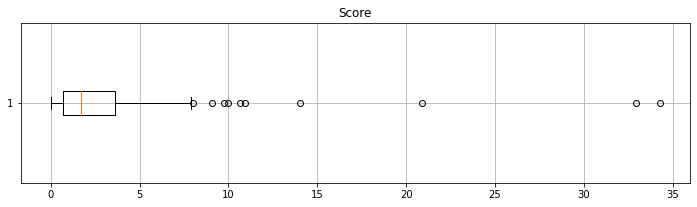

In [8]:
#Check how the elliptic envelope works, as it works best with gaussian-shaped clusters
preds_ee_float, scores_ee_float = fo_cluster0.elliptic_envelope()
#Plot boxplot
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot(3, 1, 1)
ax.boxplot(scores_ee_float, vert=False)
ax.title.set_text('Score')
ax.grid()

Contamination not specified, finding outliers above custom upper whisker: 10
Q1: 0.7134184356695958, Q2: 1.6922692128340102, Q3: 3.5808218169103263, Upper whisker: (10)


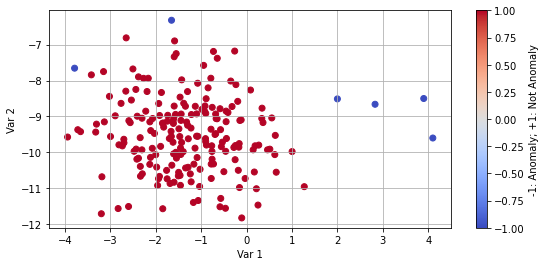

In [9]:
#Only consider outliers when they are above 10
preds_ee_float, scores_ee_float = fo_cluster0.elliptic_envelope(upper_whisker = 10)
plt.figure(figsize = (9, 4))
ax = plt.scatter(X[:,0], X[:,1], c = preds_ee_float, cmap = 'coolwarm')
plt.xlabel('Var 1')
plt.ylabel('Var 2')
plt.colorbar(label = '-1: Anomaly; +1: Not Anomaly')
plt.grid()
plt.show()

### 2.4 Manually check function behaviour

The elliptic envelope method attempts to enclose the data in an elliptic region using robust statistics. In this section we simply define the boxplot rule as a decision function and plot the data, to see that in fact thio

In [10]:
#Define custom decision function
def dec_function(Z1: np.ndarray = None, upper_wisker = None):
    result = [1 if z <= upper_wisker else 0 for z in Z1]
    return np.array(result)

Since we need to call the mahalanobis() function of the elliptic envelope, we use the get_elliptic_envelope() so that we can retrieve the saved model. All models inside the find_outliers class have this method:

* get_elliptic_envelope

* get_isolation_forest

* get_oc_svm

* get_local_outlier_factor

Text(0.5, 1.0, 'Elliptic envelope')

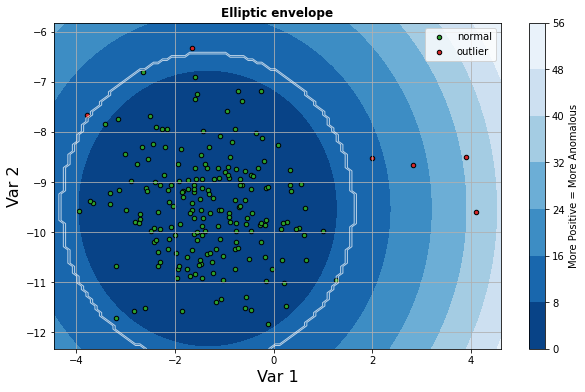

In [11]:
#Upper whisker
uw = 10
#Since the data is 2D, we can create a mesh to visualize the model's decision function
#For that, we use the get_elliptic_envelope() method to extract it from inside the class
ee = fo_cluster0.get_elliptic_envelope()
#Create mesh to visualize decision function
# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - 0.5, np.max(X[:,0]) + 0.5, 100), np.linspace(np.min(X[:,1]) - 0.5, np.max(X[:,1]) + 0.5, 100))
Z1 = ee.mahalanobis(np.c_[xx.ravel(), yy.ravel()])
Z2 = dec_function(Z1=Z1, upper_wisker=uw)
Z = Z1.reshape(xx.shape)
Z2 = Z2.reshape(xx.shape)
#Separate normal and anomalous points
normal_points = X[np.where(preds_ee_float == 1)]
anomalous_points = X[np.where(preds_ee_float == -1)]
#Plot suspicious points with decision function
plt.figure(figsize = (10, 6))

ax = plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
plt.contour(xx, yy, Z2, levels = 1, linewidths=1, colors='w', alpha = 0.7)
plt.scatter(normal_points[:,0], normal_points[:,1], c = 'tab:green', edgecolor='k', s = 20, label = 'normal')
plt.colorbar(ax, label = 'More Positive = More Anomalous')
plt.scatter(anomalous_points[:,0], anomalous_points[:,1], c = 'tab:red', edgecolor='k', s = 20, label = 'outlier')
plt.xlabel('Var 1', fontsize = 16)
plt.ylabel('Var 2', fontsize = 16)
plt.legend()
plt.grid()
plt.title('Elliptic envelope', weight = 'bold')

## 3. Predict functions

When the elliptic_envelope function is invoked, the (trained) model is saved in the specified path when creating the find_outliers instance. There exist other methods inside it which allow the user to load the model again and use it only for prediction.

Contamination not specified, finding outliers above custom upper whisker: 10
Q1: 0.7134184356695958, Q2: 1.6922692128340102, Q3: 3.5808218169103263, Upper whisker: (10)


Text(0.5, 1.0, 'Elliptic envelope with test')

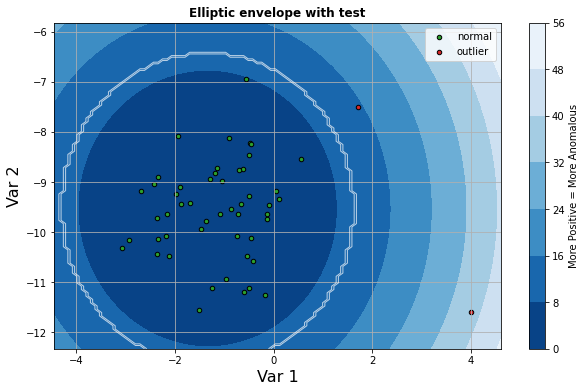

In [12]:
preds_ee_test, scores_ee_test = fo_cluster0.elliptic_envelope_predict(data = X_test, upper_whisker = 10)
#Separate normal and anomalous points
normal_points = X_test[np.where(preds_ee_test == 1)]
anomalous_points = X_test[np.where(preds_ee_test == -1)]
#Plot suspicious points with decision function
plt.figure(figsize = (10, 6))

ax = plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
plt.contour(xx, yy, Z2, levels = 1, linewidths=1, colors='w', alpha = 0.7)
plt.scatter(normal_points[:,0], normal_points[:,1], c = 'tab:green', edgecolor='k', s = 20, label = 'normal')
plt.colorbar(ax, label = 'More Positive = More Anomalous')
plt.scatter(anomalous_points[:,0], anomalous_points[:,1], c = 'tab:red', edgecolor='k', s = 20, label = 'outlier')
plt.xlabel('Var 1', fontsize = 16)
plt.ylabel('Var 2', fontsize = 16)
plt.legend()
plt.grid()
plt.title('Elliptic envelope with test', weight = 'bold')

### 3.1 All predict functions

* elliptic_envelope_predict

* isolation_forest_predict

* oc_svm_predict

* local_outlier_factor_predict

Additionally, every function has a description if the help function is executed:

In [13]:
help(find_outliers.elliptic_envelope_predict)

Help on function elliptic_envelope_predict in module AnomalyDetection:

elliptic_envelope_predict(self, data, topn: int = None, iqr_range=1.5, upper_whisker=None)
    Function used to detect outliers given a pre-trained elliptic envelope model.
    The data must still be either a pandas dataframe or numpy array, with normalized numerical variables.
    If a PCA or SVD was specified when creating the find_outliers class, the data will be transformed accordingly.
    Input:
     - data: Dataframe or numpy array with pre-processed variables (i. e. numerical variables have been scaled,
       standardized or encoded)
     - topn: Integer indicating expected amount of outliers for the test sample. If not specified, will take the one
       provided when declaring the find_outliers class. It will only be used if an integer was assigned to
       the contamination when instantiating the class, otherwise will be ignored.
     Custom variables:
     - iqr_range: Float number that scales the siz

## 4.0 Closing remarks

As it has been stated throughout the document, the best way to perform anomaly detection involves an initial step of clustering (after performing a variable selection step, of course), and then, test anomaly detection methods over the clusters separately. I believe this is the best that can be done while keeping a simple approach without custom solutions and as an unsupervised problem.

A more in-depth analysis about outlier detection can be found in https://dl.acm.org/doi/abs/10.1145/1541880.1541882

When it comes to high dimensional datasets, the local outlier factor may be the best approach https://onlinelibrary.wiley.com/doi/full/10.1002/sam.11161 but the remaining models in this code may still provide some insight.

These methods tend to work better with numerical attributes. When it comes to categorical data, the categorical embeddings may be an interesting solution. Otherwise, a custom-made algorithm or metric may be a better alternative.